In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
from pathlib import Path
import anndata as ad
import scanpy as sc
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt
sys.path.insert(0, "/home/ylu/project/spateo-release")
import spateo as st
# sys.path.insert(0, "/home/ylu/project/spateo-release_new")
# import spateo_dev as st_dev
sys.path.insert(0, "/home/ylu/project")
from utils import *
import time


%load_ext autoreload
%autoreload 2

2024-07-10 18:06:56.307898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 18:06:56.452668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.3/lib64
2024-07-10 18:06:56.452692: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-10 18:06:57.204519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot ope

In [10]:
data_folder = "../../data/STARMapPlus/"
i = 3
adata = ad.read_h5ad(os.path.join(data_folder, f"sagittal{i}.h5ad"))

In [11]:
scale = np.linalg.norm(adata.obsm['spatial'].max(0) - adata.obsm['spatial'].min(0))

In [12]:
adata

AnnData object with n_obs × n_vars = 207591 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type'
    obsm: 'spatial', 'spatial_raw'

In [13]:
slices = split_slice(
    adata=adata,
    spatial_key='spatial_raw',
    split_num=2,
    axis=2,
)

In [124]:
slices

[AnnData object with n_obs × n_vars = 103795 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
     obsm: 'spatial', 'spatial_raw',
 AnnData object with n_obs × n_vars = 103795 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
     obsm: 'spatial', 'spatial_raw',
 AnnData object with n_obs × n_vars = 1 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
     obsm: 'spatial', 'spatial_raw']

In [125]:
all_labels = adata.obs['Main_molecular_tissue_region'].cat.categories
labels_list = list(all_labels)
palette = {labels_list[i]: sns.color_palette("Paired", len(labels_list))[i] for i in range(len(labels_list))}
palette['TH'] = np.array([252,160,123]) / 255
palette['STR'] = np.array([170,214,227]) / 255
palette['LSX_HY_MB_HB'] = np.array([219,222,238]) / 255
palette['CB_1'] = np.array([250,249,213]) / 255
palette['CB_2'] = np.array([120,112,47]) / 255
palette['OB_1'] = np.array([174,114,44]) / 255
palette['OB_2'] = np.array([249,138,3]) / 255
palette['L1_HPFmo_Mngs'] = np.array([250,188,195]) / 255
palette['Hbl_VS'] = np.array([115,115,253]) / 255
palette['HPF_CA'] = np.array([145,1,212]) / 255
palette['CTX_1'] = np.array([40,182,44]) / 255
palette['CTX_2'] = np.array([96,101,45]) / 255
palette['DG'] = np.array([138,0,138]) / 255
palette['FbTrt'] = np.array([173,168,97]) / 255
# palette['TH'] = np.array([0,0,0]) / 255

In [137]:
overlay_ratio = 0.7
slice1 = slices[0].copy()
slice2 = slices[1].copy()
slice1_crop, slice2_crop = crop_slices(
    slice1, 
    slice2, 
    spatial_key='spatial', 
    overlay_ratio = overlay_ratio,
)

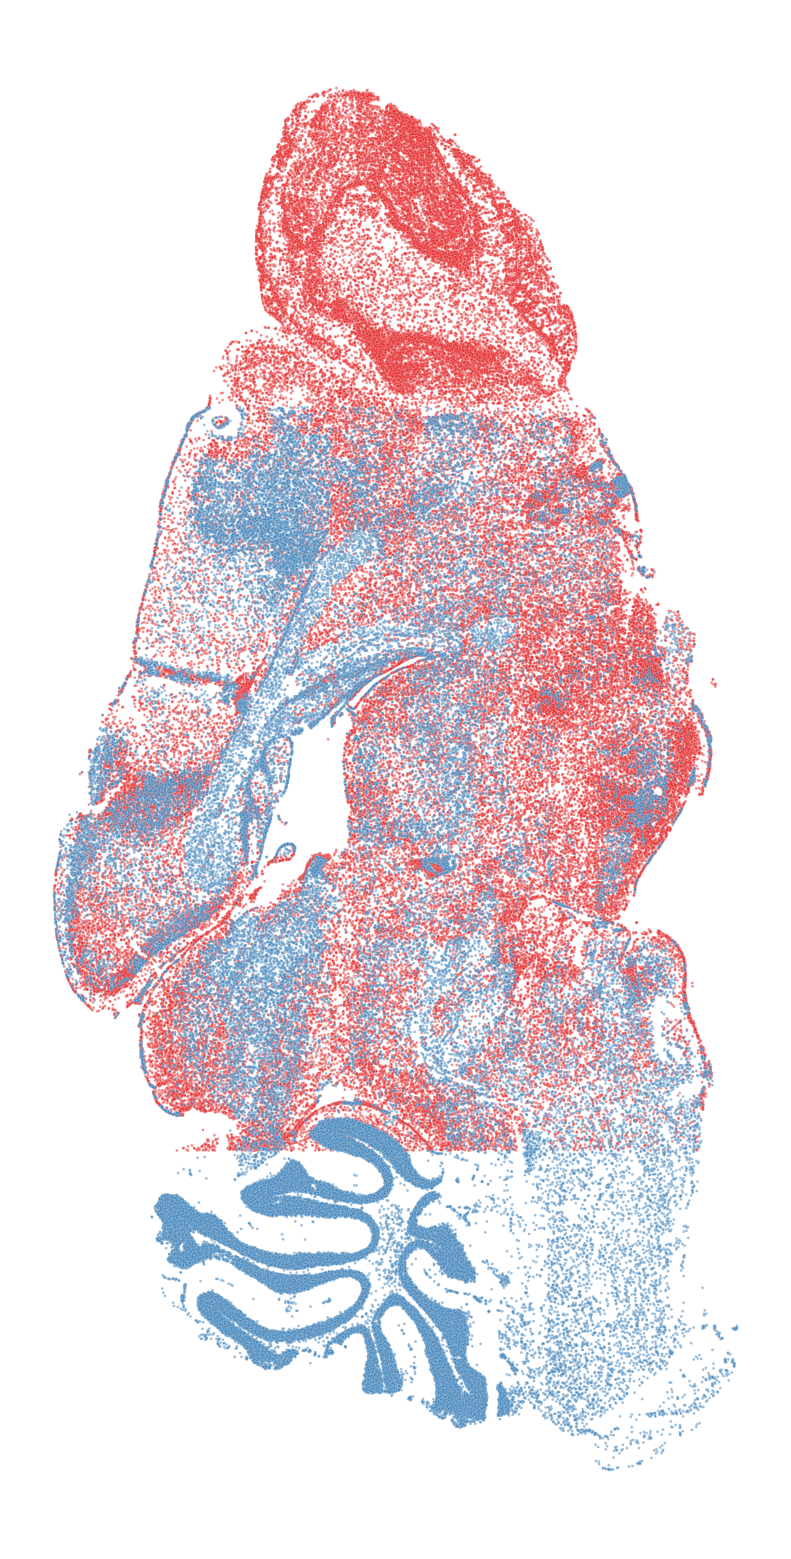

In [138]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_overlay(
    [slice1_crop, slice2_crop], 
    "spatial",
    ax,
    point_size=1,
    label_key=None,
    palette = "Set1",
    title = '',
    legend=False,
    fontsize=8,
    # n_sampling = -1,
)
plt.show()

In [139]:
spatial_key = 'spatial'
key_added = 'align_spatial'

In [140]:
adata = ad.concat([slice1_crop,slice2_crop], label='batch')
PCA(adata, 'X', 'X_pca', 50, 'cuda')
slice1_crop.obsm['X_pca'] = adata[adata.obs['batch'] == '0'].obsm['X_pca'].copy()
slice2_crop.obsm['X_pca'] = adata[adata.obs['batch'] == '1'].obsm['X_pca'].copy()

In [141]:
slice1, slice2 = slice1_crop.copy(), slice2_crop.copy()
sampling_num = 20000
sampline_idx1 = np.random.choice(slice1.shape[0], sampling_num, replace=False) if slice1.shape[0] > sampling_num else np.arange(slice1.shape[0])
sampline_idx2 = np.random.choice(slice2.shape[0], sampling_num, replace=False) if slice2.shape[0] > sampling_num else np.arange(slice2.shape[0])
slice1 = slice1[sampline_idx1,:]
slice2 = slice2[sampline_idx2,:]

In [142]:
rigid_transformation(slice2, spatial_key, 'spatial_rot')

/home/ylu/project/utils.py:401: ImplicitModificationWarning:

Setting element `.obsm['spatial_rot']` of view, initializing view as actual.



AnnData object with n_obs × n_vars = 20000 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
    obsm: 'spatial', 'spatial_raw', 'X_pca', 'spatial_rot'

In [147]:
slice1.obsm['spatial_rot'] = slice1.obsm['spatial'].copy()
spatial_key = 'spatial_rot'

In [163]:
np.exp(np.linspace(np.log(0.01), np.log(1000), 11))

array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

In [168]:
np.linspace(0.1, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [14]:
from spateo.alignment.methods.morpho_class import *
K_set = np.arange(1, 21)
overlay_ratio_set = np.arange(0.3, 1.05, 0.05)
from tqdm import tqdm
for overlay_ratio in tqdm(overlay_ratio_set):
    slice1 = slices[0].copy()
    slice2 = slices[1].copy()
    slice1_crop, slice2_crop = crop_slices(
        slice1, 
        slice2, 
        spatial_key='spatial', 
        overlay_ratio = overlay_ratio,
    )
    adata = ad.concat([slice1_crop,slice2_crop], label='batch')
    PCA(adata, 'X', 'X_pca', 50, 'cuda')
    slice1_crop.obsm['X_pca'] = adata[adata.obs['batch'] == '0'].obsm['X_pca'].copy()
    slice2_crop.obsm['X_pca'] = adata[adata.obs['batch'] == '1'].obsm['X_pca'].copy()
    slice1, slice2 = slice1_crop.copy(), slice2_crop.copy()
    sampling_num = 20000
    sampline_idx1 = np.random.choice(slice1.shape[0], sampling_num, replace=False) if slice1.shape[0] > sampling_num else np.arange(slice1.shape[0])
    sampline_idx2 = np.random.choice(slice2.shape[0], sampling_num, replace=False) if slice2.shape[0] > sampling_num else np.arange(slice2.shape[0])
    slice1 = slice1[sampline_idx1,:]
    slice2 = slice2[sampline_idx2,:]
    # rigid_transformation(slice2, 'spatial', 'spatial_rot')
    # slice1.obsm['spatial_rot'] = slice1.obsm['spatial'].copy()
    spatial_key = 'spatial'
    key_added = 'align_spatial'
    
    maes = []
    for K in K_set:
        align_slices = [slice1.copy(), slice2.copy()]
        morpho_model = Morpho_pairwise(
            sampleA=align_slices[1],
            sampleB=align_slices[0],
            spatial_key=spatial_key,
            key_added=key_added,
            
            iter_key_added=None,
            partial_robust_level=50,
            # nn_init=False,
            lambdaVF=1e5,
            beta=1e-5,
            sigma2_init_scale=1,
            device='1',
            sparse_calculation_mode=False,
            use_chunk=False,
            chunk_capacity=2,
            # rep_layer=['X'],
            # rep_field=['layer'],
            # dissimilarity=['kl'],
            rep_layer=['X_pca'],
            rep_field=['obsm'],
            dissimilarity=['cos'],
            nn_init=True,
            nn_init_weight=1,
            max_iter=400,
            batch_size=4000,
            nn_init_top_K = int(K),
            # SVI_mode=False
        )
        P = morpho_model.run()
        align_slices[1].obsm[key_added] = morpho_model.optimal_RnA.copy()
        align_slices[0].obsm[key_added] = align_slices[0].obsm[spatial_key].copy()
        spatial_align = align_slices[1].obsm[key_added]
        spatial_GT = align_slices[1].obsm['spatial']
        mae, mae_var = MAE(spatial_align, spatial_GT) / scale
        maes.append(mae)
    np.save(f'./results/K_{overlay_ratio}.npy', {'K_set': K_set, 'maes': maes}, allow_pickle=True)

  0%|                           | 0/15 [00:00<?, ?it/s]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([14854.1191, 14854.1191])...
|-----------> Scale: tensor([[17920.6738, 19796.3223],
        [21984.7793, 53029.8789]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [12.7189s]
|-----> Key Parameters: gamma: 0.4511546492576599; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([14854.1191, 14854.1191])...
|-----------> Scale: tensor([[17920.6738, 19796.3223],
        [21984.7793, 53029.8789]], device='cuda:0')...
|-----> Preprocess finished.
|----->

  7%|█               | 1/15 [05:31<1:17:24, 331.73s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([15162.4512, 15162.4512])...
|-----------> Scale: tensor([[17971.4668, 20215.8691],
        [21879.0996, 52351.0391]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [10.8171s]
|-----> Key Parameters: gamma: 0.4264577329158783; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0026, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([15162.4512, 15162.4512])...
|-----------> Scale: tensor([[17971.4668, 20215.8691],
        [21879.0996, 52351.0391]], device='cuda:0')...
|-----> Preprocess finished.
|----->

 13%|██▏             | 2/15 [11:07<1:12:23, 334.15s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([15515.7695, 15515.7695])...
|-----------> Scale: tensor([[18101.0879, 20550.5684],
        [21719.1875, 51572.6758]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [12.5459s]
|-----> Key Parameters: gamma: 0.2556188106536865; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0027, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([15515.7695, 15515.7695])...
|-----------> Scale: tensor([[18101.0879, 20550.5684],
        [21719.1875, 51572.6758]], device='cuda:0')...
|-----> Preprocess finished.
|----->

 20%|███▏            | 3/15 [16:48<1:07:29, 337.43s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([15876.5957, 15876.5957])...
|-----------> Scale: tensor([[17972.1602, 21091.5410],
        [21564.5273, 50876.1445]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [12.2379s]
|-----> Key Parameters: gamma: 0.2928697168827057; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([15876.5957, 15876.5957])...
|-----------> Scale: tensor([[17972.1602, 21091.5410],
        [21564.5273, 50876.1445]], device='cuda:0')...
|-----> Preprocess finished.
|----->

 27%|████▎           | 4/15 [22:50<1:03:35, 346.90s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([16342.7871, 16342.7871])...
|-----------> Scale: tensor([[18007.7324, 21625.9395],
        [21516.8574, 49994.6914]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [13.6757s]
|-----> Key Parameters: gamma: 0.32294297218322754; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([16342.7871, 16342.7871])...
|-----------> Scale: tensor([[18007.7324, 21625.9395],
        [21516.8574, 49994.6914]], device='cuda:0')...
|-----> Preprocess finished.
|-----

 33%|█████▎          | 5/15 [29:22<1:00:32, 363.24s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([16805.2500, 16805.2500])...
|-----------> Scale: tensor([[17948.5879, 22596.9180],
        [21520.8984, 49465.9297]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [16.1275s]
|-----> Key Parameters: gamma: 0.36559557914733887; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([16805.2500, 16805.2500])...
|-----------> Scale: tensor([[17948.5879, 22596.9180],
        [21520.8984, 49465.9297]], device='cuda:0')...
|-----> Preprocess finished.
|-----

 40%|███████▏          | 6/15 [36:10<56:46, 378.47s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([17413.4238, 17413.4238])...
|-----------> Scale: tensor([[17941.6484, 23759.3926],
        [21364.5176, 48435.0977]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [16.6841s]
|-----> Key Parameters: gamma: 0.416534960269928; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([17413.4238, 17413.4238])...
|-----------> Scale: tensor([[17941.6484, 23759.3926],
        [21364.5176, 48435.0977]], device='cuda:0')...
|-----> Preprocess finished.
|-----> 

 47%|████████▍         | 7/15 [42:30<50:30, 378.84s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([17924.8789, 17924.8789])...
|-----------> Scale: tensor([[17955.5410, 24390.5020],
        [21184.9883, 47563.7891]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [15.8250s]
|-----> Key Parameters: gamma: 0.4308146834373474; sigma2: 0.0010060720378533006; probability_parameters: [tensor(0.0024, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([17924.8789, 17924.8789])...
|-----------> Scale: tensor([[17955.5410, 24390.5020],
        [21184.9883, 47563.7891]], device='cuda:0')...
|-----> Preprocess finished.
|----->

 53%|█████████▌        | 8/15 [48:06<42:36, 365.21s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([18355.0859, 18355.0859])...
|-----------> Scale: tensor([[17987.5859, 25122.5098],
        [21265.8398, 46703.7031]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [12.4784s]
|-----> Key Parameters: gamma: 0.4733690321445465; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([18355.0859, 18355.0859])...
|-----------> Scale: tensor([[17987.5859, 25122.5098],
        [21265.8398, 46703.7031]], device='cuda:0')...
|-----> Preprocess finished.
|----->

 60%|██████████▊       | 9/15 [52:21<33:05, 330.94s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([19244.9219, 19244.9219])...
|-----------> Scale: tensor([[18174.8594, 26857.9395],
        [21048.4258, 45534.4297]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [7.7428s]
|-----> Key Parameters: gamma: 0.5235479474067688; sigma2: 0.0010002137860283256; probability_parameters: [tensor(0.0026, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([19244.9219, 19244.9219])...
|-----------> Scale: tensor([[18174.8594, 26857.9395],
        [21048.4258, 45534.4297]], device='cuda:0')...
|-----> Preprocess finished.
|-----> 

 67%|███████████▎     | 10/15 [56:15<25:04, 300.84s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([19722.0859, 19722.0859])...
|-----------> Scale: tensor([[18242.0977, 27777.4395],
        [21190.8945, 44836.9023]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [7.6335s]
|-----> Key Parameters: gamma: 0.5695657730102539; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0024, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([19722.0859, 19722.0859])...
|-----------> Scale: tensor([[18242.0977, 27777.4395],
        [21190.8945, 44836.9023]], device='cuda:0')...
|-----> Preprocess finished.
|-----> 

 73%|███████████    | 11/15 [1:00:08<18:40, 280.01s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([20188.8477, 20188.8477])...
|-----------> Scale: tensor([[18272.5391, 28014.5586],
        [21050.6270, 43775.2891]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [7.6093s]
|-----> Key Parameters: gamma: 0.5910793542861938; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0024, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([20188.8477, 20188.8477])...
|-----------> Scale: tensor([[18272.5391, 28014.5586],
        [21050.6270, 43775.2891]], device='cuda:0')...
|-----> Preprocess finished.
|-----> 

 80%|████████████   | 12/15 [1:04:02<13:18, 266.06s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([21034.9258, 21034.9258])...
|-----------> Scale: tensor([[18383.6543, 29470.2207],
        [21040.8594, 42389.8477]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [7.6856s]
|-----> Key Parameters: gamma: 0.6676391959190369; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0024, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([21034.9258, 21034.9258])...
|-----------> Scale: tensor([[18383.6543, 29470.2207],
        [21040.8594, 42389.8477]], device='cuda:0')...
|-----> Preprocess finished.
|-----> 

 87%|█████████████  | 13/15 [1:07:56<08:32, 256.41s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([22227.5352, 22227.5352])...
|-----------> Scale: tensor([[18319.0547, 31919.4043],
        [21269.7148, 41232.6602]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [7.7937s]
|-----> Key Parameters: gamma: 0.7396367192268372; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([22227.5352, 22227.5352])...
|-----------> Scale: tensor([[18319.0547, 31919.4043],
        [21269.7148, 41232.6602]], device='cuda:0')...
|-----> Preprocess finished.
|-----> 

 93%|██████████████ | 14/15 [1:11:51<04:09, 249.99s/it]

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([22768.6816, 22768.6816])...
|-----------> Scale: tensor([[18274.5117, 33390.2734],
        [21284.9434, 41090.8359]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [7.7772s]
|-----> Key Parameters: gamma: 0.7725551724433899; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0025, device='cuda:0')]
|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([22768.6816, 22768.6816])...
|-----------> Scale: tensor([[18274.5117, 33390.2734],
        [21284.9434, 41090.8359]], device='cuda:0')...
|-----> Preprocess finished.
|-----> 

100%|███████████████| 15/15 [1:15:47<00:00, 303.15s/it]


In [167]:
np.save(f'./results/lambda_{overlay_ratio}.npy', {'lambda_set': lambda_set, 'maes': maes}, allow_pickle=True)

In [ ]:
res_df = pd.DataFrame(columns=['Method', 'sampling_num', 'mae', 'mse', 'rmse', 't', 'Slice'])

In [165]:
maes

[0.001344194976820085,
 0.0013122409772533834,
 0.0013268363724702808,
 0.0013234656552413037,
 0.0013095513329812896,
 0.001266468024049188,
 0.0012989994767282213,
 0.0013855477988968207,
 0.0017271140551027824,
 0.0024467975768378593,
 0.0028726749679033013]

In [148]:
from spateo.alignment.methods.morpho_class import *
align_slices = [slice1, slice2]
morpho_model = Morpho_pairwise(
    sampleA=align_slices[1],
    sampleB=align_slices[0],
    spatial_key=spatial_key,
    key_added=key_added,
    
    iter_key_added='align_spatial_iter',
    partial_robust_level=50,
    # nn_init=False,
    lambdaVF=1e5,
    beta=1e-5,
    sigma2_init_scale=1,
    device='1',
    sparse_calculation_mode=False,
    use_chunk=False,
    chunk_capacity=2,
    # rep_layer=['X'],
    # rep_field=['layer'],
    # dissimilarity=['kl'],
    rep_layer=['X_pca'],
    rep_field=['obsm'],
    dissimilarity=['cos'],
    # probability_type=['prob'],
    # probability_parameters=[0.001],
    nn_init=True,
    nn_init_weight=1,
    max_iter=400,
    batch_size=4000
    # SVI_mode=False
)
P = morpho_model.run()

|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([18375.0137, 18375.0137])...
|-----------> Scale: tensor([[18000.8516, 25247.6445],
        [21147.5586, 46646.1719]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [7.5992s]
|-----> Key Parameters: gamma: 0.47788363695144653; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0024, device='cuda:0')]


In [149]:
# slice1.obsm[key_added] = morpho_model.XAHat.copy()
align_slices[1].obsm[key_added] = morpho_model.optimal_RnA.copy()
align_slices[0].obsm[key_added] = align_slices[0].obsm[spatial_key].copy()
align_slices[1].uns['align_spatial_iter'] = morpho_model.iter_added

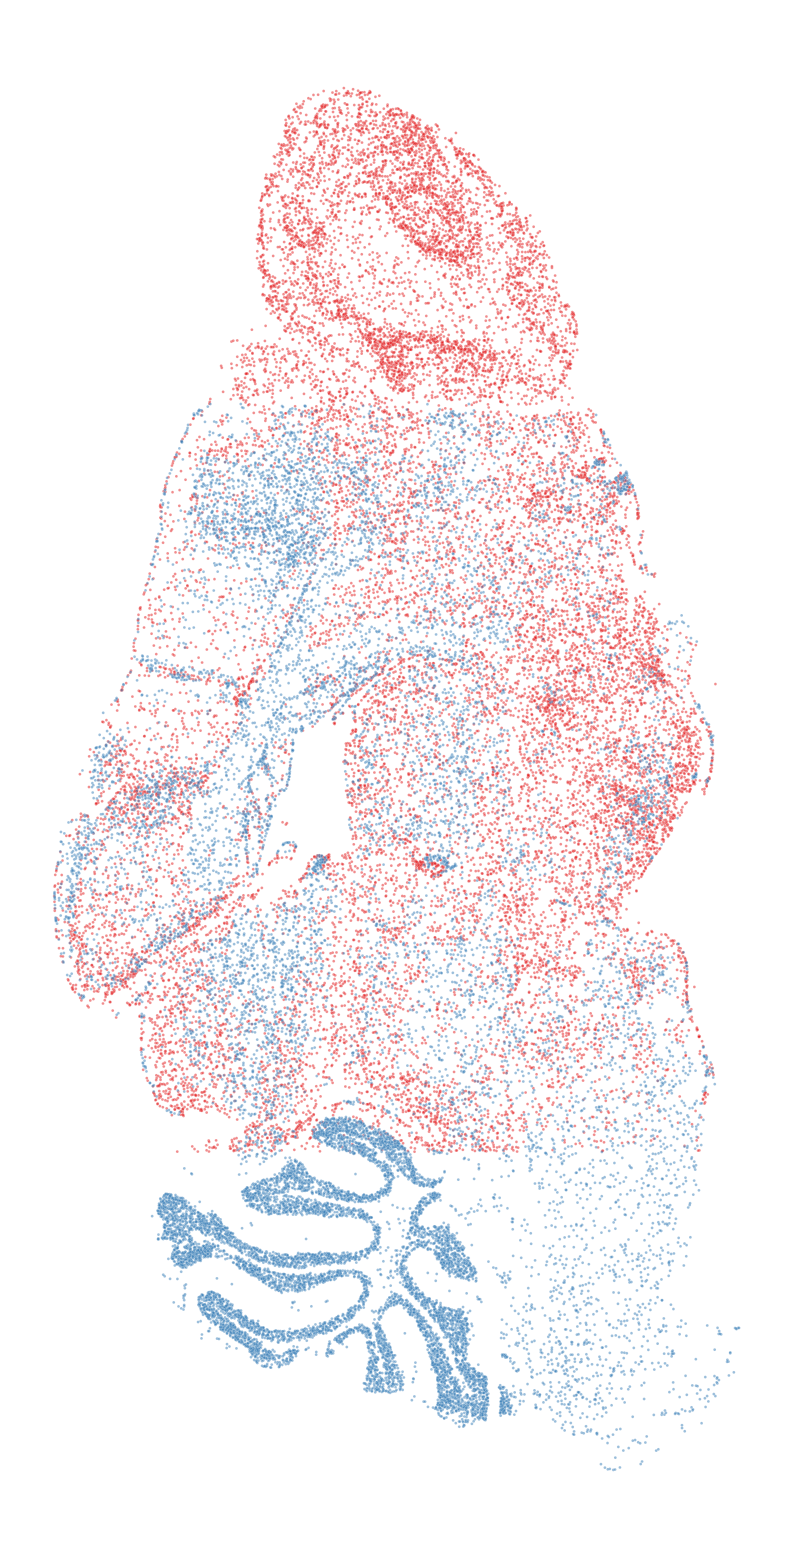

In [150]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_overlay(
    align_slices, 
    key_added,
    ax,
    point_size=1,
    label_key=None,
    palette = "Set1",
    title = '',
    legend=False,
    fontsize=8,
    # n_sampling = -1,
)
plt.show()

In [151]:
two_d_pairwise_animate(
    model_ref=align_slices[0],
    model=align_slices[1],
    spatial_key=spatial_key,
    key_added=key_added,
    iter_key_added = "align_spatial_iter",
    filename =  "Alignment_process",
    fps = 10,
    stepsize = 10,
)

In [152]:
spatial_align = align_slices[1].obsm[key_added]
spatial_GT = align_slices[1].obsm['spatial']
mae, mae_var = MAE(spatial_align, spatial_GT)
mse, mse_var = MSE(spatial_align, spatial_GT)
rmse = RMSE(spatial_align, spatial_GT)

In [154]:
scale = np.linalg.norm(adata.obsm['spatial'].max(0) - adata.obsm['spatial'].min(0))

In [155]:
scale

86246.56390202584

In [156]:
mae / scale

0.0012965989054979459